# Trabajo de aprendizaje activo

Manuel Bajo Buenestado y Kevin Craig Alisauskas

03-03-2019




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#from al_base import ao
from sklearn.cluster import KMeans
from random import randint
import random
random.seed(31415926535)

In [5]:
# se cargan los datos
U = pd.read_csv("./Datos/semeion_unlabeled.csv", header = None)
test = pd.read_csv("./Datos/semeion_test.csv", header = None)

# test
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

# labeled
L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
X_L = L.iloc[:,1:]
y_L = L.iloc[:,0]

# unlabeled
X_U = U.iloc[:,1:]
y_U = U.iloc[:,0]


already_selected = []
# El modelo sera SVC (un clasificador usando support vector machines)
model = SVC(gamma = 'auto', probability=True)


def MS(model, X_U, already_selected, N):
    distances = []
    for i in model.decision_function(X_U):
        distances.append(np.linalg.norm(i))
    distances = np.array(distances)
    rank_ind = np.argsort(distances)
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]
    return active_samples

def MCLU(model, X_U, already_selected, N):
    distances = model.predict_proba(X_U)
    sort_distances = np.sort(distances, 1)[:, -2:]
    min_margin = sort_distances[:, 1] - sort_distances[:, 0]
    rank_ind = np.argsort(min_margin)
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]
    return active_samples

def SSC(model, X_U, already_selected, N):

    pass

def random_sampling(model, X_U, already_selected, N):    
    not_selected = []
    random_samples = []
    for i in range(U.shape[0]):
        if [i in already_selected] == [False]:
            not_selected = not_selected + [i]
    for i in range(N):
        random_samples = random_samples + [randint(0, len(not_selected))]
    return random_samples

def diversity_clustering(X_U, active_samples, n):
    kmeans = KMeans(n_clusters=n).fit(X_U.iloc[active_samples])
    labels = kmeans.labels_
    diversity_samples = []

    for i in range(n):
        for j in range(len(labels)):
            if (labels[j] == i) :
                diversity_samples = diversity_samples + [active_samples[j]]
                break
    
    return diversity_samples


#### https://github.com/google/active-learning/tree/master/sampling_methods

In [3]:
### comenzamos con random sampling, que usaremos para comparar el resto de metodos
M = 30 # numero iteraciones. Se acaba con M*10 muestras etiquetadas
random_accuracy = []
L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
X_L = L.iloc[:,1:]
y_L = L.iloc[:,0]

for i in range(M):
    model.fit(X_L, y_L)

    y_pred = model.predict(X_test)

    random_accuracy = random_accuracy + [accuracy_score(y_pred, y_test)]
    active_samples = random_sampling(model, X_U, already_selected, 10)
    already_selected = already_selected + active_samples

    L = L.append(U.iloc[active_samples,])
    X_L = L.iloc[:,1:]
    y_L = L.iloc[:,0]

In [14]:
# Resto de metodos de AC + criterio_diversidad

M = 30 # numero iteraciones. Se acaba con M*n_diver muestras etiquetadas
n_al = 30 # numero de muestras activa que se seleccionan en cada iteracion
n_diver = 10 # numero de muestras que se selecionan de las muestras activas a traves de un criterio de diversidad para cada iteracion
sampling_methods = [MS, MCLU]
diversity_methods = [diversity_clustering]
acc = np.empty((len(sampling_methods)*len(diversity_methods),M))

for j in range(len(sampling_methods)):
    for k in range(len(diversity_methods)):
        accuracy = []
        already_selected = []
        L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
        X_L = L.iloc[:,1:]
        y_L = L.iloc[:,0]

        for i in range(M):
            model.fit(X_L, y_L)

            y_pred = model.predict(X_test)

            accuracy = accuracy + [accuracy_score(y_pred, y_test)]

            active_samples = sampling_methods[j](model, X_U, already_selected, n_al)
            active_samples = diversity_methods[k](X_U, active_samples, n_diver)


            already_selected = already_selected + active_samples

            L = L.append(U.iloc[active_samples,])
            X_L = L.iloc[:,1:]
            y_L = L.iloc[:,0]
        
    acc[j,:] = np.array(accuracy)
    

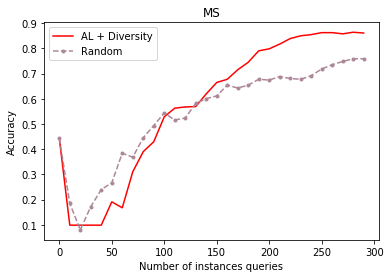

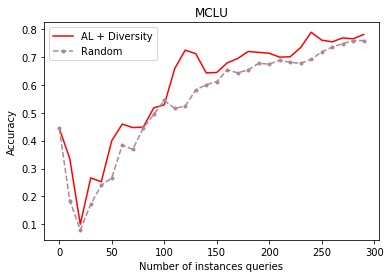

In [15]:
# Graficas (naranja es random)
al = ["MS"]*len(diversity_methods) + ["MCLU"]*len(diversity_methods)
diversity = ["Diversity Clustering"]*len(sampling_methods)
x = np.arange(M*n_diver, step = 10)

for i in range(acc.shape[0]):
    plt.figure(i)
    plt.plot(x, acc[i,:], "r")
    plt.plot(x, random_accuracy, ".--", color = "#AC8798")
    plt.title(al[i])
    plt.legend(("AL + Diversity","Random"))
    plt.ylabel("Accuracy")
    plt.xlabel("Number of instances queries")
    plt.show

In [38]:
### SSC


not_selected = [i for i in list(range(X_U.shape[0])) if i not in already_selected]
not_support = [i for i in list(range(X_L.shape[0])) if i not in model.support_]
np.array(X_U)[not_selected]
np.array(X_L)[model.support_]
not_support

array([  0,  11,  15,  21,  31,  35,  39,  65,  96, 125, 167, 242, 270,
         1,  13,  16,  24,  33,  34,  37,  53,  79,  83,  92, 101, 107,
       110, 151, 157, 164, 172, 180, 204, 211, 212, 222, 226, 233, 235,
       237, 241, 251, 254, 264, 265, 286, 290,   2,  20,  28,  47,  55,
        69,  73,  75,  76,  78,  81,  90, 116, 119, 123, 134, 142, 146,
       156, 162, 168, 169, 176, 184, 196, 216, 225, 231, 234, 245, 256,
       260, 274,   3,  29,  41,  48,  52,  56,  57,  94,  97, 103, 115,
       136, 145, 163, 170, 178, 185, 197, 232, 243, 244, 246, 248, 250,
       258, 261, 277, 293,   4,  19,  32,  38,  49,  54,  58,  62,  77,
       104, 109, 155, 165, 166, 171, 173, 186, 195, 200, 207, 209, 215,
       218, 227, 230, 236, 267, 276, 285, 287, 289, 298,   5,  40,  46,
        50,  51,  61,  71,  74,  85,  91, 112, 122, 127, 131, 133, 135,
       148, 159, 160, 187, 188, 190, 194, 201, 202, 206, 208, 217, 224,
       238, 240, 252, 253, 273, 283, 288, 295,   6,  12,  36,  4